In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from sem_seg_dataset import SegmentationDataset
import segmentation_models_pytorch as smp 
import torchmetrics



In [11]:
test_ds = SegmentationDataset(path_name='test')
test_dataloader = DataLoader(test_ds, batch_size=1, shuffle=True)

In [12]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#%% Model setup
model = smp.FPN(
    encoder_name='se_resnext50_32x4d', 
    encoder_weights='imagenet', 
    classes=6, 
    activation='sigmoid',
)
model.to(DEVICE)

#%% load weights
model.load_state_dict(torch.load('models/FPN_model_1.pth'))

<All keys matched successfully>

In [13]:
pixel_accuracies = [] 
intersection_over_unions = []
metric_iou = torchmetrics.JaccardIndex(num_classes=6, task='multiclass').to(DEVICE)

with torch.no_grad():
    for data in test_dataloader:
        inputs, outputs = data
        true = outputs.to(torch.float32) 
        pred = model(inputs.to(DEVICE).float()) 
        _, predicted = torch.max(pred, 1) 
        true = true.to(DEVICE)
        correct_pixels = (true == predicted).sum().item()
        total_pixels = true.size(1) * true.size(2)
        pixel_accuracies.append(correct_pixels / total_pixels)
        iou = metric_iou(predicted.float(), true).item()
        intersection_over_unions.append(iou)

#%% Median Accuracy
print(f"Median Pixel Accuracy: {np.median(pixel_accuracies) * 100 }")
print(f"Median IoU: {np.median(intersection_over_unions) * 100 }")


Median Pixel Accuracy: 84.3349609375
Median IoU: 31.0559019446373


(320, 320)

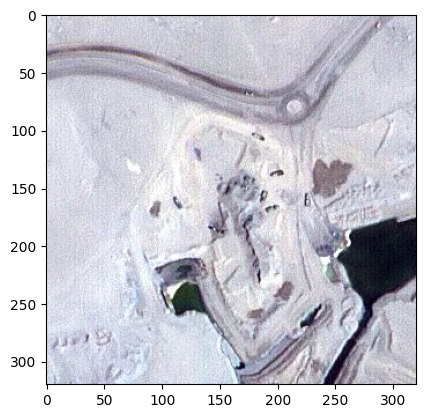

In [14]:
image_test, mask = next(iter(test_dataloader))
plt.imshow(np.transpose(image_test[0, :, :, :].cpu().numpy(), (1, 2, 0)))

#%% EVALUATE MODEL
# create preds
with torch.no_grad():
    image_test = image_test.float().to(DEVICE)
    output = model(image_test)

#%%
output_cpu = output.cpu().squeeze().numpy()
output_cpu = output_cpu.transpose((1, 2, 0))
output_cpu = output_cpu.argmax(axis=2)
output_cpu.shape

In [15]:
required_range = list(range(6))
output_cpu[0, 0] = 0
output_cpu[0, 1] = 1
output_cpu[0, 2] = 2
output_cpu[0, 3] = 3
output_cpu[0, 4] = 4
output_cpu[0, 5] = 5

mask[0, 0, 0] = 0
mask[0, 0, 1] = 1
mask[0, 0, 2] = 2
mask[0, 0, 3] = 3
mask[0, 0, 4] = 4
mask[0, 0, 5] = 5
#%%

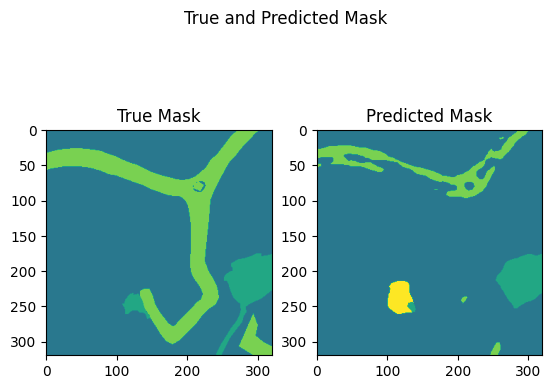

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.suptitle('True and Predicted Mask')
axs[0].imshow(mask[0, :, :])
axs[1].imshow(output_cpu)
axs[0].set_title("True Mask")
axs[1].set_title("Predicted Mask")
plt.show()